# Generate webpage content for calculation_surface_energy records

This Notebook is designed for reading finished calculation_surface_energy records and generating the associated webpage content.

#### Library imports

In [1]:
# Standard Python libraries
from __future__ import print_function
import glob
import os
from collections import OrderedDict
from copy import deepcopy

from IPython.core.display import display, HTML

# pandas.pydata.org
import pandas as pd

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/DataModelDict
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

import analysis

#### Plotting library imports

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',family='Times New Roman')
mpl.rc('lines',linewidth=3)

## 1. Read Calculation Data

This section reads in raw data from a database. 

## 1. Raw Data

This section reads in or generates the raw_data associated with the calculation. 

### 1.1 Initialize database

- __dbasename__ is used here to predefine different dbase settings
- __dbase__ is the iprPy.Database object to use for accessing a database

In [3]:
dbasename = 'iprhub'

# 'local' is a local directory
if   dbasename == 'local':
    dbase = iprPy.Database('local',   host='C:\Users\lmh1\Documents\calculations\ipr\library')

# 'test' is a local directory for testing 
if   dbasename == 'test':
    dbase = iprPy.Database('local',   host='C:\Users\lmh1\Documents\calculations\ipr\library_test')
    
# 'curator' is a local MDCS curator
elif dbasename == 'curator':
    dbase = iprPy.Database('curator', host='http://127.0.0.1:8000/', 
                                      user='admin', 
                                      pswd='admin')

# 'iprhub' is the remote MDCS curator at iprhub
elif dbasename == 'iprhub':
    dbase = iprPy.Database('curator', host='https://iprhub.nist.gov/', 
                                      user='lmh1',
                                      pswd='C:/users/lmh1/documents/iprhub/iprhub_password.txt',
                                      cert='C:/users/lmh1/documents/iprhub/iprhub-ca.pem')
else:
    raise ValueError('unknown dbasename ' + dbasename)

### 1.2 Access records

In [4]:
proto_df = dbase.get_records_df(style='crystal_prototype')
print(str(len(proto_df)) + ' prototype records loaded')

19 prototype records loaded


In [5]:
pot_df = dbase.get_records_df(style='potential_LAMMPS')
print(str(len(pot_df)) + ' potential records loaded')

156 potential records loaded


In [6]:
raw_df = dbase.get_records_df(style='calculation_generalized_stacking_fault')
print(str(len(raw_df)) + ' calculation records loaded')

610 calculation records loaded


### 1.3 Check errors

In [7]:
if 'error' in raw_df:
    for error in np.unique(raw_df[pd.notnull(raw_df.error)].error):
        print(error)
        print()

Traceback (most recent call last):
  File "calc_stacking_fault_multi.py", line 533, in <module>
    main(*sys.argv[1:])
  File "calc_stacking_fault_multi.py", line 43, in main
    process_input(input_dict, *args[1:])
  File "calc_stacking_fault_multi.py", line 527, in process_input
    iprPy.input.systemmanipulate(input_dict, build=build)
  File "c:\users\lmh1\documents\python-packages\iprpy\iprPy\input\systemmanipulate.py", line 132, in systemmanipulate
    raise ValueError('Rotation of non-cubic systems not supported yet')
ValueError: Rotation of non-cubic systems not supported yet

Traceback (most recent call last):
  File "calc_stacking_fault_multi.py", line 533, in <module>
    main(*sys.argv[1:])
  File "calc_stacking_fault_multi.py", line 60, in main
    dmax = input_dict['maxatommotion'])
  File "calc_stacking_fault_multi.py", line 431, in stackingfaultmap
    lammps_date=lammps_date))
  File "calc_stacking_fault_multi.py", line 326, in stackingfaultworker
    lammps_date=lammp

## 2. Process Data

This section processes and refines the data.

### 2.1 Identify composition

We need to identify the composition of each calculation so that we can collect duplicates and filter out artificial compounds.

- __counts__ is a dictionary counting the number of times each atype appears in a crystal prototype's unit cell (i.e. the number of symmetry equivalent sites)

In [8]:
counts = {}
for i, prototype in proto_df.iterrows():
    model = DM(dbase.get_record(name=prototype.id, style='crystal_prototype').content)
    counts[prototype.id] = np.unique(model.finds('component'), return_counts=True)[1]

- __comp_refine()__ takes a list of symbols and count of how many times each symbol appears in a structure and generates a composition string.__comp_refine__ takes a list of symbols and count of how many times each symbol appears in a structure and generates a composition string.

In [9]:
def comp_refine(symbols, counts):
    """Takes a list of symbols and count of how many times each symbol appears and generates a composition string."""
    primes = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47]
    
    sym_dict = {}
    for i in xrange(len(symbols)):
        sym_dict[symbols[i]] = counts[i]
    
    for prime in primes:
        if max(sym_dict.values()) < prime:
            break
        
        while True:
            breaktime = False
            for value in sym_dict.values():
                if value % prime != 0:
                    breaktime = True
                    break
            if breaktime:
                break
            for key in sym_dict:
                sym_dict[key] /= prime
    
    composition=''
    for key in sorted(sym_dict):
        if sym_dict[key] > 0:
            composition += key
            if sym_dict[key] != 1:
                composition += str(sym_dict[key])
            
    return composition       

In [10]:
compositions = []
for i, calc in raw_df.iterrows():
    compositions.append(comp_refine(calc.symbols, counts[calc.family]))
raw_df = raw_df.assign(composition=compositions)

In [11]:
raw_df.keys()

Index([u'LAMMPS_version', u'calc_key', u'calc_script', u'energytolerance',
       u'error', u'family', u'forcetolerance', u'gsf_plot', u'iprPy_version',
       u'load_file', u'load_options', u'load_style', u'maxatommotion',
       u'maxevaluations', u'maxiterations', u'numshifts1', u'numshifts2',
       u'potential_LAMMPS_id', u'potential_LAMMPS_key', u'potential_id',
       u'potential_key', u'shiftvector1', u'shiftvector2', u'sizemults',
       u'stackingfault_id', u'stackingfault_key', u'status', u'symbols',
       u'composition'],
      dtype='object')

In [14]:
potentials = ['2004--Liu-X-Y--Al']

Liu_Al_df = raw_df[(raw_df.potential_id.isin(potentials)) & (raw_df.composition=='Al')]
Liu_Al_df

,LAMMPS_version,calc_key,calc_script,energytolerance,error,family,forcetolerance,gsf_plot,iprPy_version,load_file,...,potential_id,potential_key,shiftvector1,shiftvector2,sizemults,stackingfault_id,stackingfault_key,status,symbols,composition
33,10 Mar 2016-ICMS,5070c77d-6b02-45cc-b0dc-55d0d6f55c3f,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,ae5bc4d6-427f-4a63-940e-674808f9290f.xml,...,2004--Liu-X-Y--Al,8f71b887-b4c5-42c0-b06c-9456153725d9,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Al],Al
458,10 Mar 2016-ICMS,4a9977bc-9bf8-4777-afd8-3a16a31f06f9,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,5dea4a98-c6a6-4cf3-9e93-b9561ea1f009.xml,...,2004--Liu-X-Y--Al,8f71b887-b4c5-42c0-b06c-9456153725d9,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Al],Al


In [15]:
os.mkdir('Liu_Al')

WindowsError: [Error 183] Cannot create a file when that file already exists: 'Liu_Al'

In [16]:
for calc_key in Liu_Al_df.calc_key.values:
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('Liu_Al', calc_key+'.xml'), 'w') as f:
        f.write(record.content)
for load_file in Liu_Al_df.load_file.values:
    calc_key = os.path.splitext(load_file)[0]
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('Liu_Al', calc_key+'.xml'), 'w') as f:
        f.write(record.content)

In [21]:
potentials = ['1997--Liu-X-Y--Al-Mg', '1999--Liu-X-Y--Al-Cu']

ercolessi_Al_df = raw_df[(raw_df.potential_id.isin(potentials)) & (raw_df.composition=='Al')]
ercolessi_Al_df

,LAMMPS_version,calc_key,calc_script,energytolerance,error,family,forcetolerance,gsf_plot,iprPy_version,load_file,...,potential_id,potential_key,shiftvector1,shiftvector2,sizemults,stackingfault_id,stackingfault_key,status,symbols,composition
52,10 Mar 2016-ICMS,a3061ec7-eedd-4d6a-b887-872022c640b2,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,41d871d0-6bbf-4f78-abfc-a920e5da72c8.xml,...,1999--Liu-X-Y--Al-Cu,92e1a9a3-8124-4808-9fd9-fa5e4abef227,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Al],Al
105,10 Mar 2016-ICMS,4bce5619-5de9-4f09-888f-fd3050447ec7,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shif...,0.7.2,78017ce9-6336-4c86-b6ad-a53e62510e68.xml,...,1999--Liu-X-Y--Al-Cu,92e1a9a3-8124-4808-9fd9-fa5e4abef227,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Al],Al
245,10 Mar 2016-ICMS,4c410c19-c158-4353-ab88-7f625d28a831,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,34cf3d94-9d2f-46ef-b411-da473ff06694.xml,...,1997--Liu-X-Y--Al-Mg,b702ae33-5d66-40fb-84e6-f2840555459a,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Al],Al
339,10 Mar 2016-ICMS,7d5a59ec-c29c-43a1-8b18-749b29a9fbc9,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,9a6e427d-ee90-4ae3-9daf-78671be02bed.xml,...,1997--Liu-X-Y--Al-Mg,b702ae33-5d66-40fb-84e6-f2840555459a,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Al],Al
508,10 Mar 2016-ICMS,2e0b1733-fd21-4b03-a906-794f9fe35baf,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0 ...,0.7.2,7718ce7e-7dd8-4882-acbc-5b1889ed2748.xml,...,1997--Liu-X-Y--Al-Mg,b702ae33-5d66-40fb-84e6-f2840555459a,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Al],Al
530,10 Mar 2016-ICMS,0ec59571-3e5c-4c38-bb52-0a88abe5a27e,calc_stacking_fault_multi,0.0,parent calculation issued an error,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",NaN,0.7.2,0ae1ef9a-9c8c-4468-ac8e-67c8ddc4714c.xml,...,1997--Liu-X-Y--Al-Mg,b702ae33-5d66-40fb-84e6-f2840555459a,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,error,[Al],Al


In [25]:
for calc_key in ercolessi_Al_df.calc_key.values:
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('Ercolessi_Al', calc_key+'.xml'), 'w') as f:
        f.write(record.content)
for load_file in ercolessi_Al_df.load_file.values:
    calc_key = os.path.splitext(load_file)[0]
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('Ercolessi_Al', calc_key+'.xml'), 'w') as f:
        f.write(record.content)

In [25]:
for calc_key in ercolessi_Al_df.calc_key.values:
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('Ercolessi_Al', calc_key+'.xml'), 'w') as f:
        f.write(record.content)
for load_file in ercolessi_Al_df.load_file.values:
    calc_key = os.path.splitext(load_file)[0]
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('Ercolessi_Al', calc_key+'.xml'), 'w') as f:
        f.write(record.content)

In [32]:
np.unique(raw_df.potential_id)

array([u'1985--Foiles-S-M--Ni-Cu', u'1987--Ackland-G-J--Ag',
       u'1987--Ackland-G-J--Au', u'1987--Ackland-G-J--Cu',
       u'1987--Ackland-G-J--Mo', u'1987--Ackland-G-J--Ni',
       u'1989--Adams-J-B--Ag', u'1989--Adams-J-B--Au',
       u'1989--Adams-J-B--Cu', u'1989--Adams-J-B--Ni',
       u'1989--Adams-J-B--Pd', u'1989--Adams-J-B--Pt',
       u'1995--Angelo-J-E--Ni-Al-H', u'1996--Farkas-D--Nb-Ti-Al',
       u'1997--Ackland-G-J--Fe', u'1997--Liu-X-Y--Al-Mg',
       u'1998--Liu-X-Y--Al-Mg', u'1999--Liu-X-Y--Al-Cu',
       u'1999--Mishin-Y--Al', u'1999--Mishin-Y--Ni',
       u'2000--Landa-A--Al-Pb', u'2000--Sturgeon-J-B--Al',
       u'2001--Mishin-Y--Cu-1', u'2002--Mishin-Y--Ni-Al',
       u'2003--Han-S--Cs', u'2003--Han-S--K', u'2003--Han-S--Li',
       u'2003--Han-S--Na', u'2003--Han-S--Rb', u'2003--Han-S--V',
       u'2003--Han-S--W', u'2003--Hoyt-J-J--Cu-Pb', u'2003--Li-Y-H--Ta',
       u'2003--Mendelev-M-I--Fe-2', u'2003--Mendelev-M-I--Fe-5',
       u'2003--Zope-R-R--Al', u'200

In [33]:
potentials = ['2001--Mishin-Y--Cu-1', '2006--Williams-P-L--Cu-Ag', '1997--Ackland-G-J--Fe']

other_df = raw_df[(raw_df.potential_id.isin(potentials))]
other_df

,LAMMPS_version,calc_key,calc_script,energytolerance,error,family,forcetolerance,gsf_plot,iprPy_version,load_file,...,potential_id,potential_key,shiftvector1,shiftvector2,sizemults,stackingfault_id,stackingfault_key,status,symbols,composition
64,10 Mar 2016-ICMS,2965ec12-3d43-4233-8612-2c4d5c635046,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,01eaecc3-3f06-4dd4-b907-ba7728dcc50d.xml,...,2006--Williams-P-L--Cu-Ag,cfe3a54f-c3b2-4b61-8b03-165613bdd829,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Ag],Ag
95,10 Mar 2016-ICMS,3b13acf6-4c9e-4914-a992-c3b4028d2572,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,8d1f9e5e-856c-41cf-b8ea-bffd8cc6e5c7.xml,...,1997--Ackland-G-J--Fe,372f9e5f-dcbd-4cc6-902a-ebcafd664018,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Fe],Fe
129,10 Mar 2016-ICMS,9980a065-30d3-4c86-adcf-411bf21a9549,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,8559209c-5c9d-40b0-bfa5-98641ba62610.xml,...,1997--Ackland-G-J--Fe,372f9e5f-dcbd-4cc6-902a-ebcafd664018,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Fe],Fe
151,10 Mar 2016-ICMS,f3a6a438-6c0d-45ce-bc86-f8fdcf2e8a9f,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,a7faacbe-0184-4f4d-8236-1dec13afb782.xml,...,2006--Williams-P-L--Cu-Ag,cfe3a54f-c3b2-4b61-8b03-165613bdd829,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Cu],Cu
227,10 Mar 2016-ICMS,c36a6ff3-16ee-4464-b62b-ad0fe88661f7,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,54b5e5f6-0ef9-468b-aa56-ce4570eeeff0.xml,...,2001--Mishin-Y--Cu-1,5a94a06a-22c7-41e0-8593-ee42d4728018,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Cu],Cu
257,10 Mar 2016-ICMS,6de0f932-a329-4e25-b8c0-2041bf8193a9,calc_stacking_fault_multi,0.0,NaN,A2--W--bcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,22a2ba61-95fb-4415-b017-fba906824ef8.xml,...,1997--Ackland-G-J--Fe,372f9e5f-dcbd-4cc6-902a-ebcafd664018,0.5 0.5 0.5,1.0 -1.0 0.0,"[[0, 5], [0, 5], [0, 10]]",A2--W--bcc--112sf,e92a955f-dcc9-43b9-95bb-2c413d082972,finished,[Fe],Fe
258,10 Mar 2016-ICMS,940c10c0-2fee-49f7-9668-2b8c2153eb5b,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,e5e52c63-1626-43c3-98fe-156b131ae803.xml,...,2001--Mishin-Y--Cu-1,5a94a06a-22c7-41e0-8593-ee42d4728018,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Cu],Cu
308,10 Mar 2016-ICMS,b5c9066e-eea2-4341-b379-ba37839baa60,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,d743fd52-af16-4c6a-833c-c63690c3fdba.xml,...,2006--Williams-P-L--Cu-Ag,cfe3a54f-c3b2-4b61-8b03-165613bdd829,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--111sf,dfb2cdad-46b0-4164-8cb2-4eb55a84f0ba,finished,[Ag],Ag
311,10 Mar 2016-ICMS,af9bc91a-1c7c-4b3f-9ab0-801851ad211a,calc_stacking_fault_multi,0.0,NaN,A1--Cu--fcc,"{u'value': 1e-06, u'unit': u'eV/angstrom'}",energy separation shift1 shift2 0...,0.7.2,9898faed-d621-48af-adf4-421d9b472bba.xml,...,2006--Williams-P-L--Cu-Ag,cfe3a54f-c3b2-4b61-8b03-165613bdd829,0.5 -0.5 0.0,0.5 0.5 -1.0,"[[0, 5], [0, 5], [0, 10]]",A1--Cu--fcc--1

In [34]:
for calc_key in other_df.calc_key.values:
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('other', calc_key+'.xml'), 'w') as f:
        f.write(record.content)
for load_file in other_df.load_file.values:
    calc_key = os.path.splitext(load_file)[0]
    record = dbase.get_record(name=calc_key)
    with open(os.path.join('other', calc_key+'.xml'), 'w') as f:
        f.write(record.content)

Ercolessi_Al\2e0b1733-fd21-4b03-a906-794f9fe35baf.xml


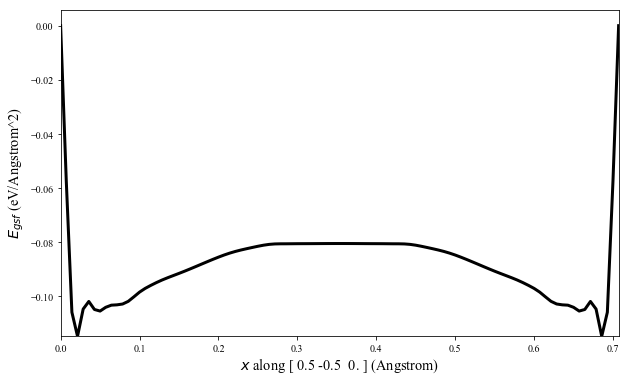

Ercolessi_Al\4bce5619-5de9-4f09-888f-fd3050447ec7.xml


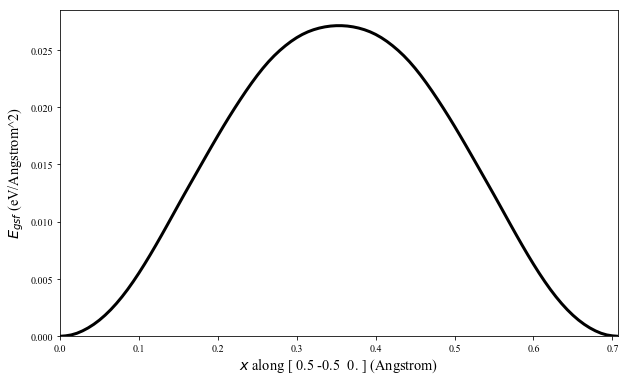

Ercolessi_Al\4c410c19-c158-4353-ab88-7f625d28a831.xml


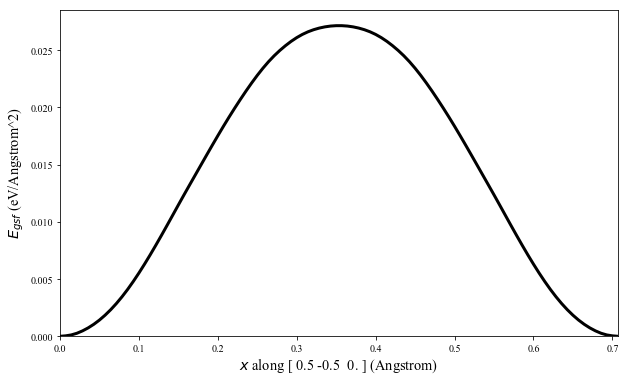

Ercolessi_Al\7d5a59ec-c29c-43a1-8b18-749b29a9fbc9.xml


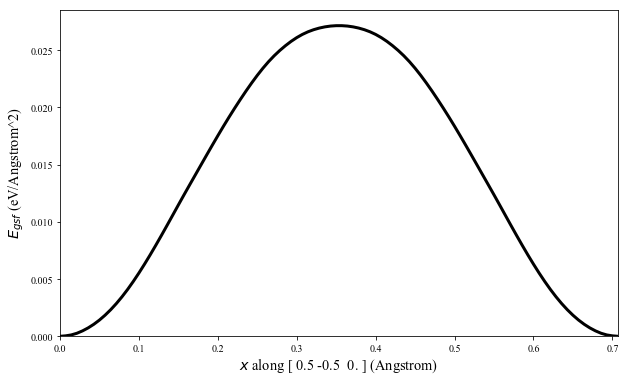

Ercolessi_Al\a3061ec7-eedd-4d6a-b887-872022c640b2.xml


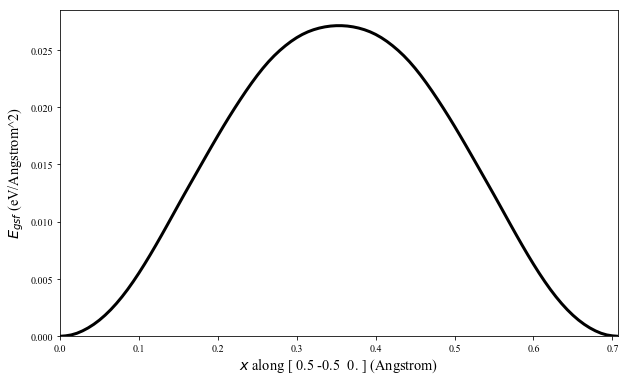

In [30]:
for record in glob.iglob(os.path.join('Ercolessi_Al', '*.xml')):
    try:
        gamma = am.defect.GammaSurface(model=record)
    except:
        pass
    else:
        print(record)
        gamma.E_gsf_line_plot()
        plt.show()

In [14]:
raw_df[['calc_key', 'potential_LAMMPS_id', u'stackingfault_id']].sort_values('potential_LAMMPS_id')

,calc_key,potential_LAMMPS_id,stackingfault_id
188,efa0a585-58ca-46ce-823d-5a707da0f294,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,A1--Cu--fcc--111sf
270,825d7244-e031-40a1-82c5-9c36691a2dac,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,A1--Cu--fcc--111sf
224,14f01a8c-9584-402e-b97f-c4d9418c25ea,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,A1--Cu--fcc--111sf
47,b129d3f5-1a99-4659-8351-b0f4a6dfa229,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,A1--Cu--fcc--111sf
25,b6f15ce8-1f63-4e14-9b1f-f1f6cea78111,1987--Ackland-G-J--Ag--LAMMPS--ipr1,A1--Cu--fcc--111sf
359,41edb06c-062d-49b2-ab5b-37b4df60ccff,1987--Ackland-G-J--Ag--LAMMPS--ipr1,A1--Cu--fcc--111sf
44,cc38a76c-3279-43bd-a6c1-f35e26df8e53,1987--Ackland-G-J--Au--LAMMPS--ipr1,A1--Cu--fcc--111sf
278,aec7e138-e9e5-428a-922a-2c9afcdf9de3,1987--Ackland-G-J--Au--LAMMPS--ipr1,A1--Cu--fcc--111sf
341,2cae0ebf-fbd9-42f9-95e8-d7e43bf91e45,1987--Ackland-G-J--Cu--LAMMPS--ipr1,A1--Cu--fcc--111sf
449,de2419bc-bfee-45d4-8f13-89b4c4c98f03,1987--Ackland-G-J--Cu--LAMMPS--ipr1,A1--Cu--fcc--111sf


In [21]:
raw_df.gamma_fs = uc.get_in_units(raw_df.gamma_fs, 'J/m^2')
Al_df = raw_df[(raw_df.surface_id == 'A1--Cu--fcc--111')
              &(raw_df.composition == 'Al')
              ]
              

In [22]:
Al_df[[u'potential_LAMMPS_id', u'gamma_fs']].sort_values(u'potential_LAMMPS_id')

,potential_LAMMPS_id,gamma_fs
783,1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1,1.000434
1161,1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1,1.000434
765,1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1,1.438696
165,1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1,1.438696
946,1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1,0.879983
1052,1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1,0.000004
957,1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1,0.879983
205,1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1,NaN
691,1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1,0.912321
706,1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1,0.912321


### 2.2 Identify current ipr potentials 

In [12]:
# Extract versionstyle and versionnumber from potential implementation ids
versionstyle = []
versionnumber = []
for name in pot_df['id'].values:
    version = name.split('--')[-1]
    try:
        versionnumber.append(int(version[-1]))
    except:
        versionnumber.append(np.nan)
        versionstyle.append(version)
    else:
        versionstyle.append(version[:-1])

pot_df['versionstyle'] = versionstyle
pot_df['versionnumber'] = versionnumber

# Loop through unique potential id's
includeid = []
for pot_id in np.unique(pot_df.pot_id.values):
    check_df = pot_df[pot_df.pot_id == pot_id]
    check_df = check_df[check_df.versionstyle == 'ipr']
    check_df = check_df[check_df.versionnumber == check_df.versionnumber.max()]
    if len(check_df) == 1:
        includeid.append(check_df['id'].values[0])
    elif len(check_df) > 1:
        raise ValueError('Bad currentIPR check for '+pot_id)

# Identify current IPR potentials
raw_df['currentIPR'] = raw_df.potential_LAMMPS_id.isin(includeid)

### 2.4 Remove unwanted calculations

Here is where we filter out unwanted entries (i.e. rows).

- __df__ is the dataframe during/after processing and refining

In [13]:
raw_df.keys()

Index([u'E_coh', u'LAMMPS_version', u'calc_key', u'calc_script',
       u'energytolerance', u'error', u'family', u'forcetolerance', u'gamma_fs',
       u'iprPy_version', u'load_file', u'load_options', u'load_style',
       u'maxatommotion', u'maxevaluations', u'maxiterations',
       u'potential_LAMMPS_id', u'potential_LAMMPS_key', u'potential_id',
       u'potential_key', u'sizemults', u'status', u'surface_id',
       u'surface_key', u'symbols', u'composition', u'currentIPR'],
      dtype='object')

In [14]:
df = deepcopy(raw_df)

# Ignore unfinished or error calculations
df = df[df.status == 'finished']

# Ignore any implementations that are not current IPR implementations
df = df[df.currentIPR == True]

# Ignore false compounds (where # of unique symbols != # of symbols)
df = df[df.symbols.apply(lambda x: len(np.unique(x))) == df.symbols.apply(lambda x: len(x))] 

# Ignore duplicate compounds
ignore = set()
for i in xrange(len(df)):
    trunc = df.iloc[i+1:]
    matches = trunc.calc_key[  (trunc.potential_id == df.iloc[i].potential_id) 
                             & (trunc.family == df.iloc[i].family) 
                             & (trunc.composition == df.iloc[i].composition)
                             & np.isclose(trunc.gamma_fs, df.iloc[i].gamma_fs, atol=1e-6, rtol=0.0)
                            ].tolist()
    ignore = ignore.union(matches)
df = df[~df.calc_key.isin(ignore)]

df.reset_index(drop=True, inplace=True)
print(str(len(df)) + ' records after filtering')

565 records after filtering


### 2.5 Filter out extra data

Here, we limit the DataFrame to only the data that we care about (i.e. columns).

- __headers__ gives the list of data columns from raw_data to include in and how they should be renamed in data.

In [15]:
#                        raw names       new names
headers = OrderedDict([ ('potential_id', 'potential'  ),
                        ('family',       'family'     ),
                        ('composition',  'composition'),
                        ('surface_id',   'surface'),
                        ('gamma_fs',     'gamma_fs'),
                      ])

df = pd.DataFrame(df, columns=headers.keys())
df.rename(columns=headers, inplace=True)
df

,potential,family,composition,surface,gamma_fs
0,2009--Purja-Pun-G-P--Ni-Al,A1--Cu--fcc,Al,A1--Cu--fcc--100,5.889428e-02
1,2009--Purja-Pun-G-P--Ni-Al,A1--Cu--fcc,Ni,A1--Cu--fcc--100,1.208378e-01
2,2009--Purja-Pun-G-P--Ni-Al,A1--Cu--fcc,Ni,A1--Cu--fcc--111,1.097941e-01
3,2009--Purja-Pun-G-P--Ni-Al,A1--Cu--fcc,Ni,A1--Cu--fcc--110,1.302651e-01
4,2009--Purja-Pun-G-P--Ni-Al,A1--Cu--fcc,Al,A1--Cu--fcc--111,5.433366e-02
5,2009--Purja-Pun-G-P--Ni-Al,A1--Cu--fcc,Al,A1--Cu--fcc--110,6.279126e-02
6,2004--Zhou-X-W--Pt,A1--Cu--fcc,Pt,A1--Cu--fcc--100,1.359166e-01
7,2003--Li-Y-H--Ta,A2--W--bcc,Ta,A2--W--bcc--110,1.096666e-01
8,2015--Purja-Pun-G-P--Cu-Ta,A1--Cu--fcc,Cu,A1--Cu--fcc--111,-2.135168e-194
9,2017--Smirnova-D-E--Zr-Nb,A2--W--bcc,Nb,A2--W--bcc--110,5.426477e-05


## 3. HTML Tables

This section takes the processed data and generates per_potential html tables.

In [16]:
html_info_file = 'html info.html'
with open(html_info_file) as f:
    html_info = f.read()
display(HTML(html_info))

In [17]:
table_style_file = '../calculation_system_relax/webtablestyle.html'

In [23]:
showSelectionScript = '<script type="text/javascript" src="analysis/showSelection.js"></script>\n'

In [18]:
with open(table_style_file) as f:
    table_style = f.read() 
#table_style=''

In [20]:
def gen_surf_table(df, potential):
    
    headers = OrderedDict([ ('surface', 'surface'),
                            ('gamma_fs', '<i>&gamma;<sub>fs</sub></i> (mJ/m<sup>2</sup>)'),
                            ])
    def float_fmt(value):
        return '%8.4f' % value
    
    pot_df = df[df.potential==potential]
    tables = OrderedDict()
    
    for composition in np.unique(pot_df.composition):
        comp_df = pot_df[pot_df.composition==composition]
        for family in np.unique(comp_df.family):
            table_df = comp_df[comp_df.family==family].sort_values('gamma_fs')
            table_df = pd.DataFrame(table_df, columns=headers.keys())

            table_df.gamma_fs = uc.get_in_units(table_df.gamma_fs, 'mJ/m^2')

            surfacenames = []
            for surface in table_df.surface:
                surfacenames.append('(' + surface.replace(family+'--', '') +')')
            table_df.surface = surfacenames
            
            table_df.rename(columns=headers, inplace=True)
            table_df.reset_index(drop=True, inplace=True)
            html = table_df.to_html(index=False, float_format=float_fmt, escape=False, classes='datatable')
            tables[composition + ' ' + family] = html
        
    return 'Select structure: ' + analysis.showSelection('Surface', tables)

In [24]:
html = showSelectionScript+table_style
html += gen_surf_table(df, '2009--Purja-Pun-G-P--Ni-Al')
display(HTML(html))

surface,γfs (mJ/m2)
(111),870.5212
(100),943.5903
(110),1006.0268
surface,γfs (mJ/m2)
(111),1759.0961
(100),1936.0355
(110),2087.0767


## 4. Generate for all potentials

#### Generation parameters

- __savedir__ is the directory where the files will be saved.

In [25]:
savedir = '../webcontent/perpotential'

In [26]:
# Loop over all potentials
for potential in np.unique(df.potential):
    print(potential)

    # Generate html content
    html = html_info
    html += gen_surf_table(df, potential)
    
    with open(os.path.join(savedir, potential, 'Surface.html'), 'w') as f:
        f.write(html)

1985--Foiles-S-M--Ni-Cu
1987--Ackland-G-J--Ag
1987--Ackland-G-J--Au
1987--Ackland-G-J--Cu
1987--Ackland-G-J--Mo
1987--Ackland-G-J--Ni
1989--Adams-J-B--Ag
1989--Adams-J-B--Au
1989--Adams-J-B--Cu
1989--Adams-J-B--Ni
1989--Adams-J-B--Pd
1989--Adams-J-B--Pt
1995--Angelo-J-E--Ni-Al-H
1996--Farkas-D--Nb-Ti-Al
1997--Ackland-G-J--Fe
1997--Liu-X-Y--Al-Mg
1998--Liu-X-Y--Al-Mg
1999--Liu-X-Y--Al-Cu
1999--Mishin-Y--Al
1999--Mishin-Y--Ni
2000--Landa-A--Al-Pb
2000--Sturgeon-J-B--Al
2001--Mishin-Y--Cu-1
2002--Mishin-Y--Ni-Al
2003--Han-S--Cs
2003--Han-S--K
2003--Han-S--Li
2003--Han-S--Na
2003--Han-S--Rb
2003--Han-S--V
2003--Han-S--W
2003--Hoyt-J-J--Cu-Pb
2003--Li-Y-H--Ta
2003--Mendelev-M-I--Fe-2
2003--Mendelev-M-I--Fe-5
2003--Zope-R-R--Al
2003--Zope-R-R--Ti-Al
2004--Ackland-G-J--Fe-P
2004--Liu-X-Y--Al
2004--Mishin-Y--Ni-Al
2004--Zhou-X-W--Ag
2004--Zhou-X-W--Al
2004--Zhou-X-W--Au
2004--Zhou-X-W--Cu
2004--Zhou-X-W--Fe
2004--Zhou-X-W--Mo
2004--Zhou-X-W--Ni
2004--Zhou-X-W--Pb
2004--Zhou-X-W--Pd
2004--Zhou-